# **Import Dataset**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.stats.proportion as sp

import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df_raw = pd.read_csv('loan_data_2007_2014.csv')

# **A. Data Understanding**

## **Data Summary**

In [3]:
print(f'Jumlah Baris:',df_raw.shape[0])
print(f'Jumlah kolom:',df_raw.shape[1])

Jumlah Baris: 466285
Jumlah kolom: 75


In [4]:
print(f'Total data duplikat secara keseluruhan:', df_raw.duplicated().sum())
print(f'Total data duplikat dari id:', df_raw.duplicated(subset=['id']).sum())

Total data duplikat secara keseluruhan: 0
Total data duplikat dari id: 0


## **Data Columns**

In [5]:
df_raw.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verificatio

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

### **Define Target Variable/Labeling**

Dalam project credit risk modeling, tujuan utama adalah untuk melakukan prediksi terhadap suatu individu akan kemampuan mereka untuk melakukan pembayaran terhadap pinjaman/kredit yang diberikan. Oleh karena itu, variabel target yang digunakan harus mencerminkan kemampuan individu dalam hal tersebut.

Dalam dataset ini, variabel loan_status adalah variabel yang dapat dijadikan variabel target karena mencerminkan performa masing-masing individu dalam melakukan pembayaran terhadap pinjaman/kredit selama ini.

In [7]:
df_raw.loan_status.value_counts(normalize=True)*100

loan_status
Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: proportion, dtype: float64

Dapat dilihat bahwa variabel loan_status memiliki beberapa nilai:

Current artinya pembayaran lancar; Charged Off artinya pembayaran macet sehingga dihapusbukukan; Late artinya pembayaran telat dilakukan; In Grace Period artinya dalam masa tenggang; Fully Paid artinya pembayaran lunas; Default artinya pembayaran macet

Dari definisi-definisi tersebut, masing-masing individu dapat ditandai apakah mereka merupakan bad loan (peminjam yang buruk) atau good loan (peminjam yang baik)

Definisi bad dan good loan terkadang bisa berbeda tergantung dari kebutuhan bisnis. Pada contoh ini, saya menggunakan keterlambatan pembayaran di atas 30 hari dan yang lebih buruk dari itu sebagai penanda bad loan.

In [8]:
bad_status = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']

df_raw['bad_flag'] = np.where(df_raw['loan_status'].isin(bad_status), 1, 0)

In [9]:
df_raw['bad_flag'].value_counts(normalize=True)*100

bad_flag
0    89.069346
1    10.930654
Name: proportion, dtype: float64

Setelah melakukan flagging terhadap bad/good loan, dapat dilihat bahwa jumlah individu yang ditandai sebagai bad loan jauh lebih sedikit daripada good loan. Hal ini menyebabkan problem ini menjadi problem imbalanced dataset.

Loan_status akan didrop setelah melakukan EDA.

kolom id dan member_id didrop karena tidak diperlukan dalam analisis.

In [10]:
df_raw = df_raw.drop(['id', 'member_id'], axis=1)

## **Descriptive Statistics**

In [11]:
# Select columns with dtype 'int', 'float64', and object
nums = df_raw.select_dtypes(include=['int', 'float64'])
cats = df_raw.select_dtypes(include=['object'])

nums_col = nums.columns
cats_col = cats.columns

print(f"Columns with type int and float64:", nums_col)
print(f"Columns with type object:", cats_col)

Columns with type int and float64: Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'bad_flag

In [12]:
df_raw[nums_col].describe()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,bad_flag
count,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,...,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0,466285.000000
mean,233142.000000,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,...,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN,0.109307
std,134605.029472,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,...,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN,0.312024
min,0.000000,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,0.000000
25%,116571.000000,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN,0.000000
50%,233142.000000,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN,0.000000
75%,349713.000000,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN,0.000000
max,466284.000000,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,33.000000,...,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN,1.000000


In [13]:
df_raw[cats_col].describe()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,...,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,...,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,...,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285


## **Null Value**

In [14]:
null_value = df_raw.isnull().sum() * 100 / df_raw.shape[0]
null_value = null_value[null_value > 30]
columns_null_value = null_value.index.tolist()

print(null_value)
print(columns_null_value)

desc                            72.981975
mths_since_last_delinq          53.690554
mths_since_last_record          86.566585
next_pymnt_d                    48.728567
mths_since_last_major_derog     78.773926
annual_inc_joint               100.000000
dti_joint                      100.000000
verification_status_joint      100.000000
open_acc_6m                    100.000000
open_il_6m                     100.000000
open_il_12m                    100.000000
open_il_24m                    100.000000
mths_since_rcnt_il             100.000000
total_bal_il                   100.000000
il_util                        100.000000
open_rv_12m                    100.000000
open_rv_24m                    100.000000
max_bal_bc                     100.000000
all_util                       100.000000
inq_fi                         100.000000
total_cu_tl                    100.000000
inq_last_12m                   100.000000
dtype: float64
['desc', 'mths_since_last_delinq', 'mths_since_last_record', 

In [15]:
df_new = df_raw.drop(['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'], axis=1)

In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  466285 non-null  int64  
 1   loan_amnt                   466285 non-null  int64  
 2   funded_amnt                 466285 non-null  int64  
 3   funded_amnt_inv             466285 non-null  float64
 4   term                        466285 non-null  object 
 5   int_rate                    466285 non-null  float64
 6   installment                 466285 non-null  float64
 7   grade                       466285 non-null  object 
 8   sub_grade                   466285 non-null  object 
 9   emp_title                   438697 non-null  object 
 10  emp_length                  445277 non-null  object 
 11  home_ownership              466285 non-null  object 
 12  annual_inc                  466281 non-null  float64
 13  verification_s

## **Feature Engineering**

Pada step ini, dilakukan pembersihan/modifikasi beberapa fitur ke dalam format yang dapat digunakan untuk modeling. Tahap ini dilakukan dengan melihat isi dari kolom yang bertipe object. Jika kolom tersebut dapat diconvert menjadi numerik, maka kolom tersebut akan dilakukan pengubahan.

In [17]:
cat_eng = df_new.select_dtypes(include=['object'])

cat_eng_col = cats.columns

print(f"Columns with type object:", cat_eng_col)

Columns with type object: Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype='object')


In [18]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   loan_amnt                    466285 non-null  int64  
 2   funded_amnt                  466285 non-null  int64  
 3   funded_amnt_inv              466285 non-null  float64
 4   term                         466285 non-null  object 
 5   int_rate                     466285 non-null  float64
 6   installment                  466285 non-null  float64
 7   grade                        466285 non-null  object 
 8   sub_grade                    466285 non-null  object 
 9   emp_title                    438697 non-null  object 
 10  emp_length                   445277 non-null  object 
 11  home_ownership               466285 non-null  object 
 12  annual_inc                   466281 non-null  float64
 13 

In [19]:
df_eng = df_new[['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type']]

In [20]:
df_eng.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,Apr-99,f,Apr-13,Sep-13,INDIVIDUAL
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,Jan-16,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,Feb-96,f,Jan-15,Jan-15,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,Jan-96,f,Jan-16,Jan-16,INDIVIDUAL


In [21]:
df_new1 = df_new.copy()

### **term**

Memodifikasi term. Contoh: 60 months -> 60

In [22]:
df_new1['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [23]:
df_new1['term_int'] = df_new1['term'].str.replace(' months', '')

In [24]:
df_new1['term_int'].unique()

array([' 36', ' 60'], dtype=object)

In [25]:
df_new1['term_int'] = df_new1['term_int'].astype(float)
df_new1.drop('term', axis=1, inplace=True)

In [26]:
df_new1.columns

Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'bad_flag', 'term_int'],
      dtype='object')

### **emp_length**

In [27]:
df_new1['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

Memodifikasi emp_length. Contoh: 1 year menjadi 1

In [28]:
df_new1['emp_length_int'] = df_new1['emp_length'].str.replace('\+ years', '')
df_new1['emp_length_int'] = df_new1['emp_length_int'].str.replace('< 1 year', str(0))
df_new1['emp_length_int'] = df_new1['emp_length_int'].str.replace(' years', '')
df_new1['emp_length_int'] = df_new1['emp_length_int'].str.replace(' year', '')
df_new1['emp_length_int'] = df_new1['emp_length_int'].str.replace('+', '')

In [29]:
df_new1['emp_length_int'].unique()

array(['10', '0', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan],
      dtype=object)

In [30]:
df_new1['emp_length_int'] = df_new1['emp_length_int'].astype(float)

In [31]:
df_new1.drop('emp_length', axis=1, inplace=True)

In [32]:
df_new1.columns

Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'bad_flag', 'term_int', 'emp_length_int'],
      dtype='object')

### **earliest_cr_line**

Memodifikasi earliest_cr_line dari format bulan-tahun menjadi perhitungan berapa lama waktu berlalu sejak waktu tersebut. Untuk melakukan hal ini, umumnya digunakan reference date = hari ini. Namun, karena dataset ini merupakan dataset tahun 2007-2014, maka akan lebih relevan jika menggunakan reference date di sekitar tahun 2017. Dalam contoh ini, saya menggunakan tanggal 2017-12-01 sebagai reference date.

In [33]:
df_new1['earliest_cr_line'].head(5)

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

In [34]:
df_new1['earliest_cr_line_date'] = pd.to_datetime(df_new1['earliest_cr_line'], format='%b-%y')
df_new1['earliest_cr_line_date'].head(5)

0   1985-01-01
1   1999-04-01
2   2001-11-01
3   1996-02-01
4   1996-01-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [35]:
df_new1['earliest_cr_line_date'] = pd.to_datetime(df_new1['earliest_cr_line_date'])

# Tanggal referensi
ref_date = pd.to_datetime('2017-12-01')

# Menghitung selisih bulan
def calculate_month_diff(date1, date2):
    return (date1.year - date2.year) * 12 + date1.month - date2.month

df_new1['mths_since_earliest_cr_line'] = df_new1['earliest_cr_line_date'].apply(lambda x: calculate_month_diff(ref_date, x))
print(df_new1[['earliest_cr_line_date', 'mths_since_earliest_cr_line']])

       earliest_cr_line_date  mths_since_earliest_cr_line
0                 1985-01-01                        395.0
1                 1999-04-01                        224.0
2                 2001-11-01                        193.0
3                 1996-02-01                        262.0
4                 1996-01-01                        263.0
...                      ...                          ...
466280            2003-04-01                        176.0
466281            1997-06-01                        246.0
466282            2001-12-01                        192.0
466283            2003-02-01                        178.0
466284            2000-02-01                        214.0

[466285 rows x 2 columns]


In [36]:
df_new1['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [37]:
df_new1[df_new1['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(5)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0


Nilai negatif pada kolom mths_since_earliest_cr_line muncul karena fungsi Python salah menginterpretasikan tahun 62 menjadi tahun 2062, padahal seharusnya merupakan tahun 1962.

Untuk mengatasi hal ini, dapat dilakukan preprocessing lebih jauh jika ingin membenarkan tahun 2062 menjadi 1962. Namun, pada project ini akan dibuat nilai yang negatif menjadi nilai maximum dari fitur tersebut. Karena di sini saya mengetahui bahwa nilai-nilai yang negatif artinya adalah data yang sudah tua (tahun 1900an), maka masih masuk akal jika saya mengganti nilai-nilai tersebut menjadi nilai terbesar.

In [38]:
df_new1.loc[df_new1['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = df_new1['mths_since_earliest_cr_line'].max()

In [39]:
df_new1.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1, inplace=True)

### **issue_d**

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel earliest_cr_line

In [40]:
# Konversi kolom issue_d menjadi datetime
df_new1['issue_d_date'] = pd.to_datetime(df_new1['issue_d'], format='%b-%y')

# Tanggal referensi
ref_date = pd.to_datetime('2017-12-01')

# Fungsi untuk menghitung selisih bulan
def calculate_month_diff(date1, date2):
    return (date1.year - date2.year) * 12 + date1.month - date2.month

# Terapkan fungsi ke kolom issue_d_date
df_new1['mths_since_issue_d'] = df_new1['issue_d_date'].apply(lambda x: calculate_month_diff(ref_date, x))

# Menampilkan hasil
print(df_new1[['issue_d', 'issue_d_date', 'mths_since_issue_d']])

       issue_d issue_d_date  mths_since_issue_d
0       Dec-11   2011-12-01                  72
1       Dec-11   2011-12-01                  72
2       Dec-11   2011-12-01                  72
3       Dec-11   2011-12-01                  72
4       Dec-11   2011-12-01                  72
...        ...          ...                 ...
466280  Jan-14   2014-01-01                  47
466281  Jan-14   2014-01-01                  47
466282  Jan-14   2014-01-01                  47
466283  Jan-14   2014-01-01                  47
466284  Jan-14   2014-01-01                  47

[466285 rows x 3 columns]


In [41]:
df_new1['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [42]:
df_new1.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

In [43]:
df_new1.columns

Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'url',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'bad_flag', 'term_int', 'emp_length_int', 'mths_since_earliest_cr_line',
       'mths_since_issue_d'],
      dtype='object')

### **last_pymnt_d**

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel earliest_cr_line

In [44]:
# Konversi kolom last_pymnt_d menjadi datetime
df_new1['last_pymnt_d_date'] = pd.to_datetime(df_new1['last_pymnt_d'], format='%b-%y')

# Tanggal referensi
ref_date = pd.to_datetime('2017-12-01')

# Fungsi untuk menghitung selisih bulan
def calculate_month_diff(date1, date2):
    return (date1.year - date2.year) * 12 + date1.month - date2.month

# Terapkan fungsi ke kolom last_pymnt_d_date
df_new1['mths_since_last_pymnt_d'] = df_new1['last_pymnt_d_date'].apply(lambda x: calculate_month_diff(ref_date, x))

# Menampilkan hasil
print(df_new1[['last_pymnt_d', 'last_pymnt_d_date', 'mths_since_last_pymnt_d']])

       last_pymnt_d last_pymnt_d_date  mths_since_last_pymnt_d
0            Jan-15        2015-01-01                     35.0
1            Apr-13        2013-04-01                     56.0
2            Jun-14        2014-06-01                     42.0
3            Jan-15        2015-01-01                     35.0
4            Jan-16        2016-01-01                     23.0
...             ...               ...                      ...
466280       Jan-16        2016-01-01                     23.0
466281       Dec-14        2014-12-01                     36.0
466282       Jan-16        2016-01-01                     23.0
466283       Dec-14        2014-12-01                     36.0
466284       Jan-16        2016-01-01                     23.0

[466285 rows x 3 columns]


In [45]:
df_new1['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         31.294369
std          12.809898
min          23.000000
25%          23.000000
50%          24.000000
75%          35.000000
max         120.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [46]:
df_new1.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

In [47]:
df_new1.columns

Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'url',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'bad_flag', 'term_int',
       'emp_length_int', 'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d'],
      dtype='object')

### **last_credit_pull_d**

Konsep preprocessing yang dilakukan sama dengan yang dilakukan terhadap variabel earliest_cr_line

In [48]:
# Konversi kolom last_credit_pull_d menjadi datetime
df_new1['last_credit_pull_d_date'] = pd.to_datetime(df_new1['last_credit_pull_d'], format='%b-%y')

# Tanggal referensi
ref_date = pd.to_datetime('2017-12-01')

# Fungsi untuk menghitung selisih bulan
def calculate_month_diff(date1, date2):
    return (date1.year - date2.year) * 12 + date1.month - date2.month

# Terapkan fungsi ke kolom last_credit_pull_d_date
df_new1['mths_since_last_credit_pull_d'] = df_new1['last_credit_pull_d_date'].apply(lambda x: calculate_month_diff(ref_date, x))

# Menampilkan hasil
print(df_new1[['last_credit_pull_d', 'last_credit_pull_d_date', 'mths_since_last_credit_pull_d']])

       last_credit_pull_d last_credit_pull_d_date  \
0                  Jan-16              2016-01-01   
1                  Sep-13              2013-09-01   
2                  Jan-16              2016-01-01   
3                  Jan-15              2015-01-01   
4                  Jan-16              2016-01-01   
...                   ...                     ...   
466280             Jan-16              2016-01-01   
466281             Jan-16              2016-01-01   
466282             Dec-15              2015-12-01   
466283             Apr-15              2015-04-01   
466284             Jan-16              2016-01-01   

        mths_since_last_credit_pull_d  
0                                23.0  
1                                51.0  
2                                23.0  
3                                35.0  
4                                23.0  
...                               ...  
466280                           23.0  
466281                           23.0  
466

In [49]:
df_new1['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         27.045588
std           9.636423
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         127.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [50]:
df_new1.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

In [51]:
df_new1.columns

Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'url',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'bad_flag', 'term_int', 'emp_length_int',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'],
      dtype='object')

In [52]:
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 52 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     466285 non-null  int64  
 1   loan_amnt                      466285 non-null  int64  
 2   funded_amnt                    466285 non-null  int64  
 3   funded_amnt_inv                466285 non-null  float64
 4   int_rate                       466285 non-null  float64
 5   installment                    466285 non-null  float64
 6   grade                          466285 non-null  object 
 7   sub_grade                      466285 non-null  object 
 8   emp_title                      438697 non-null  object 
 9   home_ownership                 466285 non-null  object 
 10  annual_inc                     466281 non-null  float64
 11  verification_status            466285 non-null  object 
 12  loan_status                   

# **B. Exploratory Data Analysis (EDA)**

In [157]:
df_eda = df_new1.copy()

In [230]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 52 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     466285 non-null  int64  
 1   loan_amnt                      466285 non-null  int64  
 2   funded_amnt                    466285 non-null  int64  
 3   funded_amnt_inv                466285 non-null  float64
 4   int_rate                       466285 non-null  float64
 5   installment                    466285 non-null  float64
 6   grade                          466285 non-null  object 
 7   sub_grade                      466285 non-null  object 
 8   emp_title                      438697 non-null  object 
 9   home_ownership                 466285 non-null  object 
 10  annual_inc                     466281 non-null  float64
 11  verification_status            466285 non-null  object 
 12  loan_status                   

In [233]:
# Select columns with dtype 'int', 'float64', and object
num_eda = df_eda.select_dtypes(include=['int', 'float64'])
cat_eda = df_eda.select_dtypes(include=['object'])

num_col_eda = num_eda.columns
cat_col_eda = cat_eda.columns

print(f"Columns with type int and float64:", num_col_eda)
print(f"Columns with type object:", cat_col_eda)

Columns with type int and float64: Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'bad_flag',
       'term_int', 'emp_length_int', 'mths_since_earliest_cr_line',
       'mths_since_issue_d', 'mths_since_last_pymnt_d',
       'mths_since_last_credit_pull_d'],
      dtype='object')
Columns with type object: Index(['grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'loan_status', 'pymnt_plan', 'url', 'purpose',
       'title', 'zip_code', 'addr_state', 'ini

## **Correlation**

<Axes: >

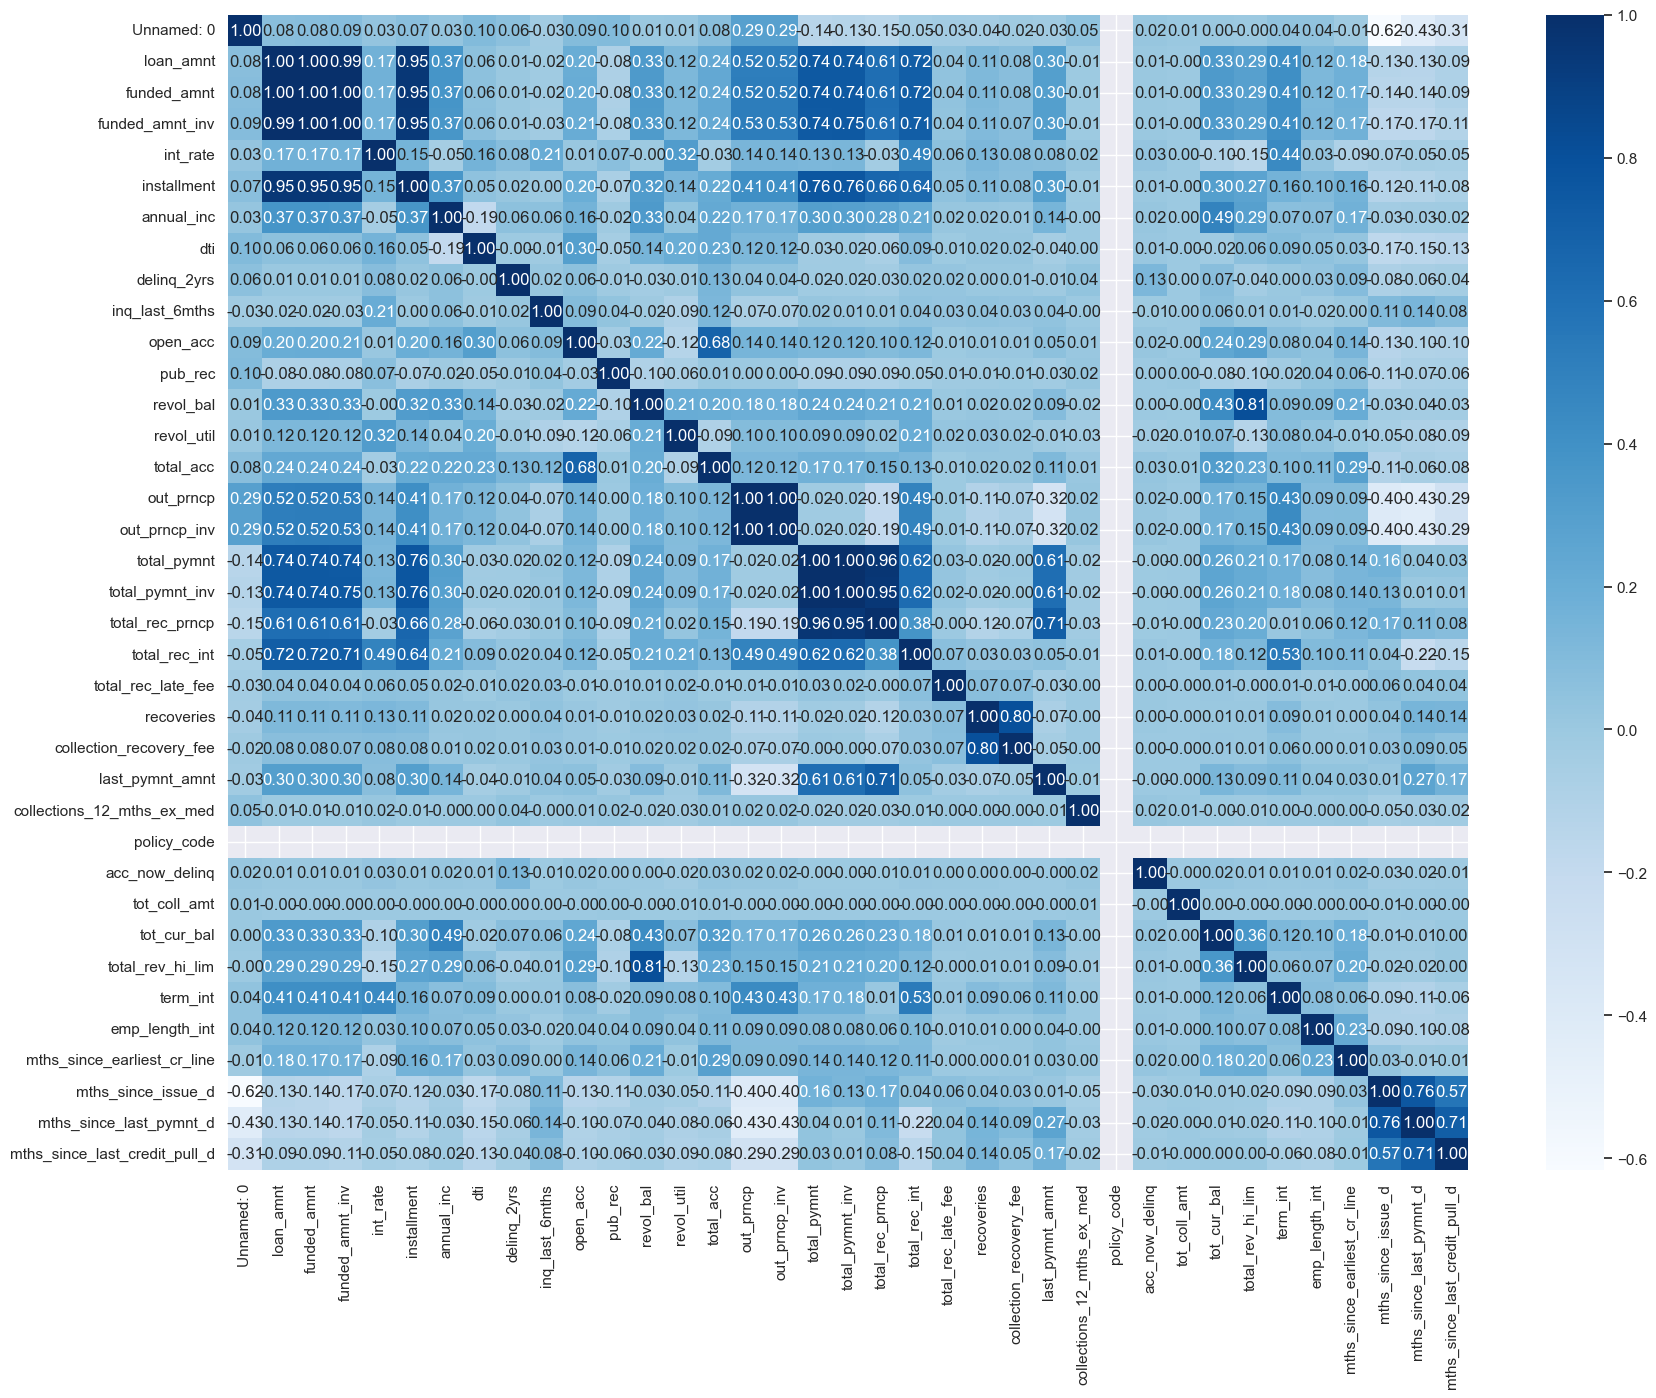

In [234]:
numeric_df = df_eda.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), cmap='Blues', annot=True, fmt='.2f')

## **Numerical Univariate Statistics**

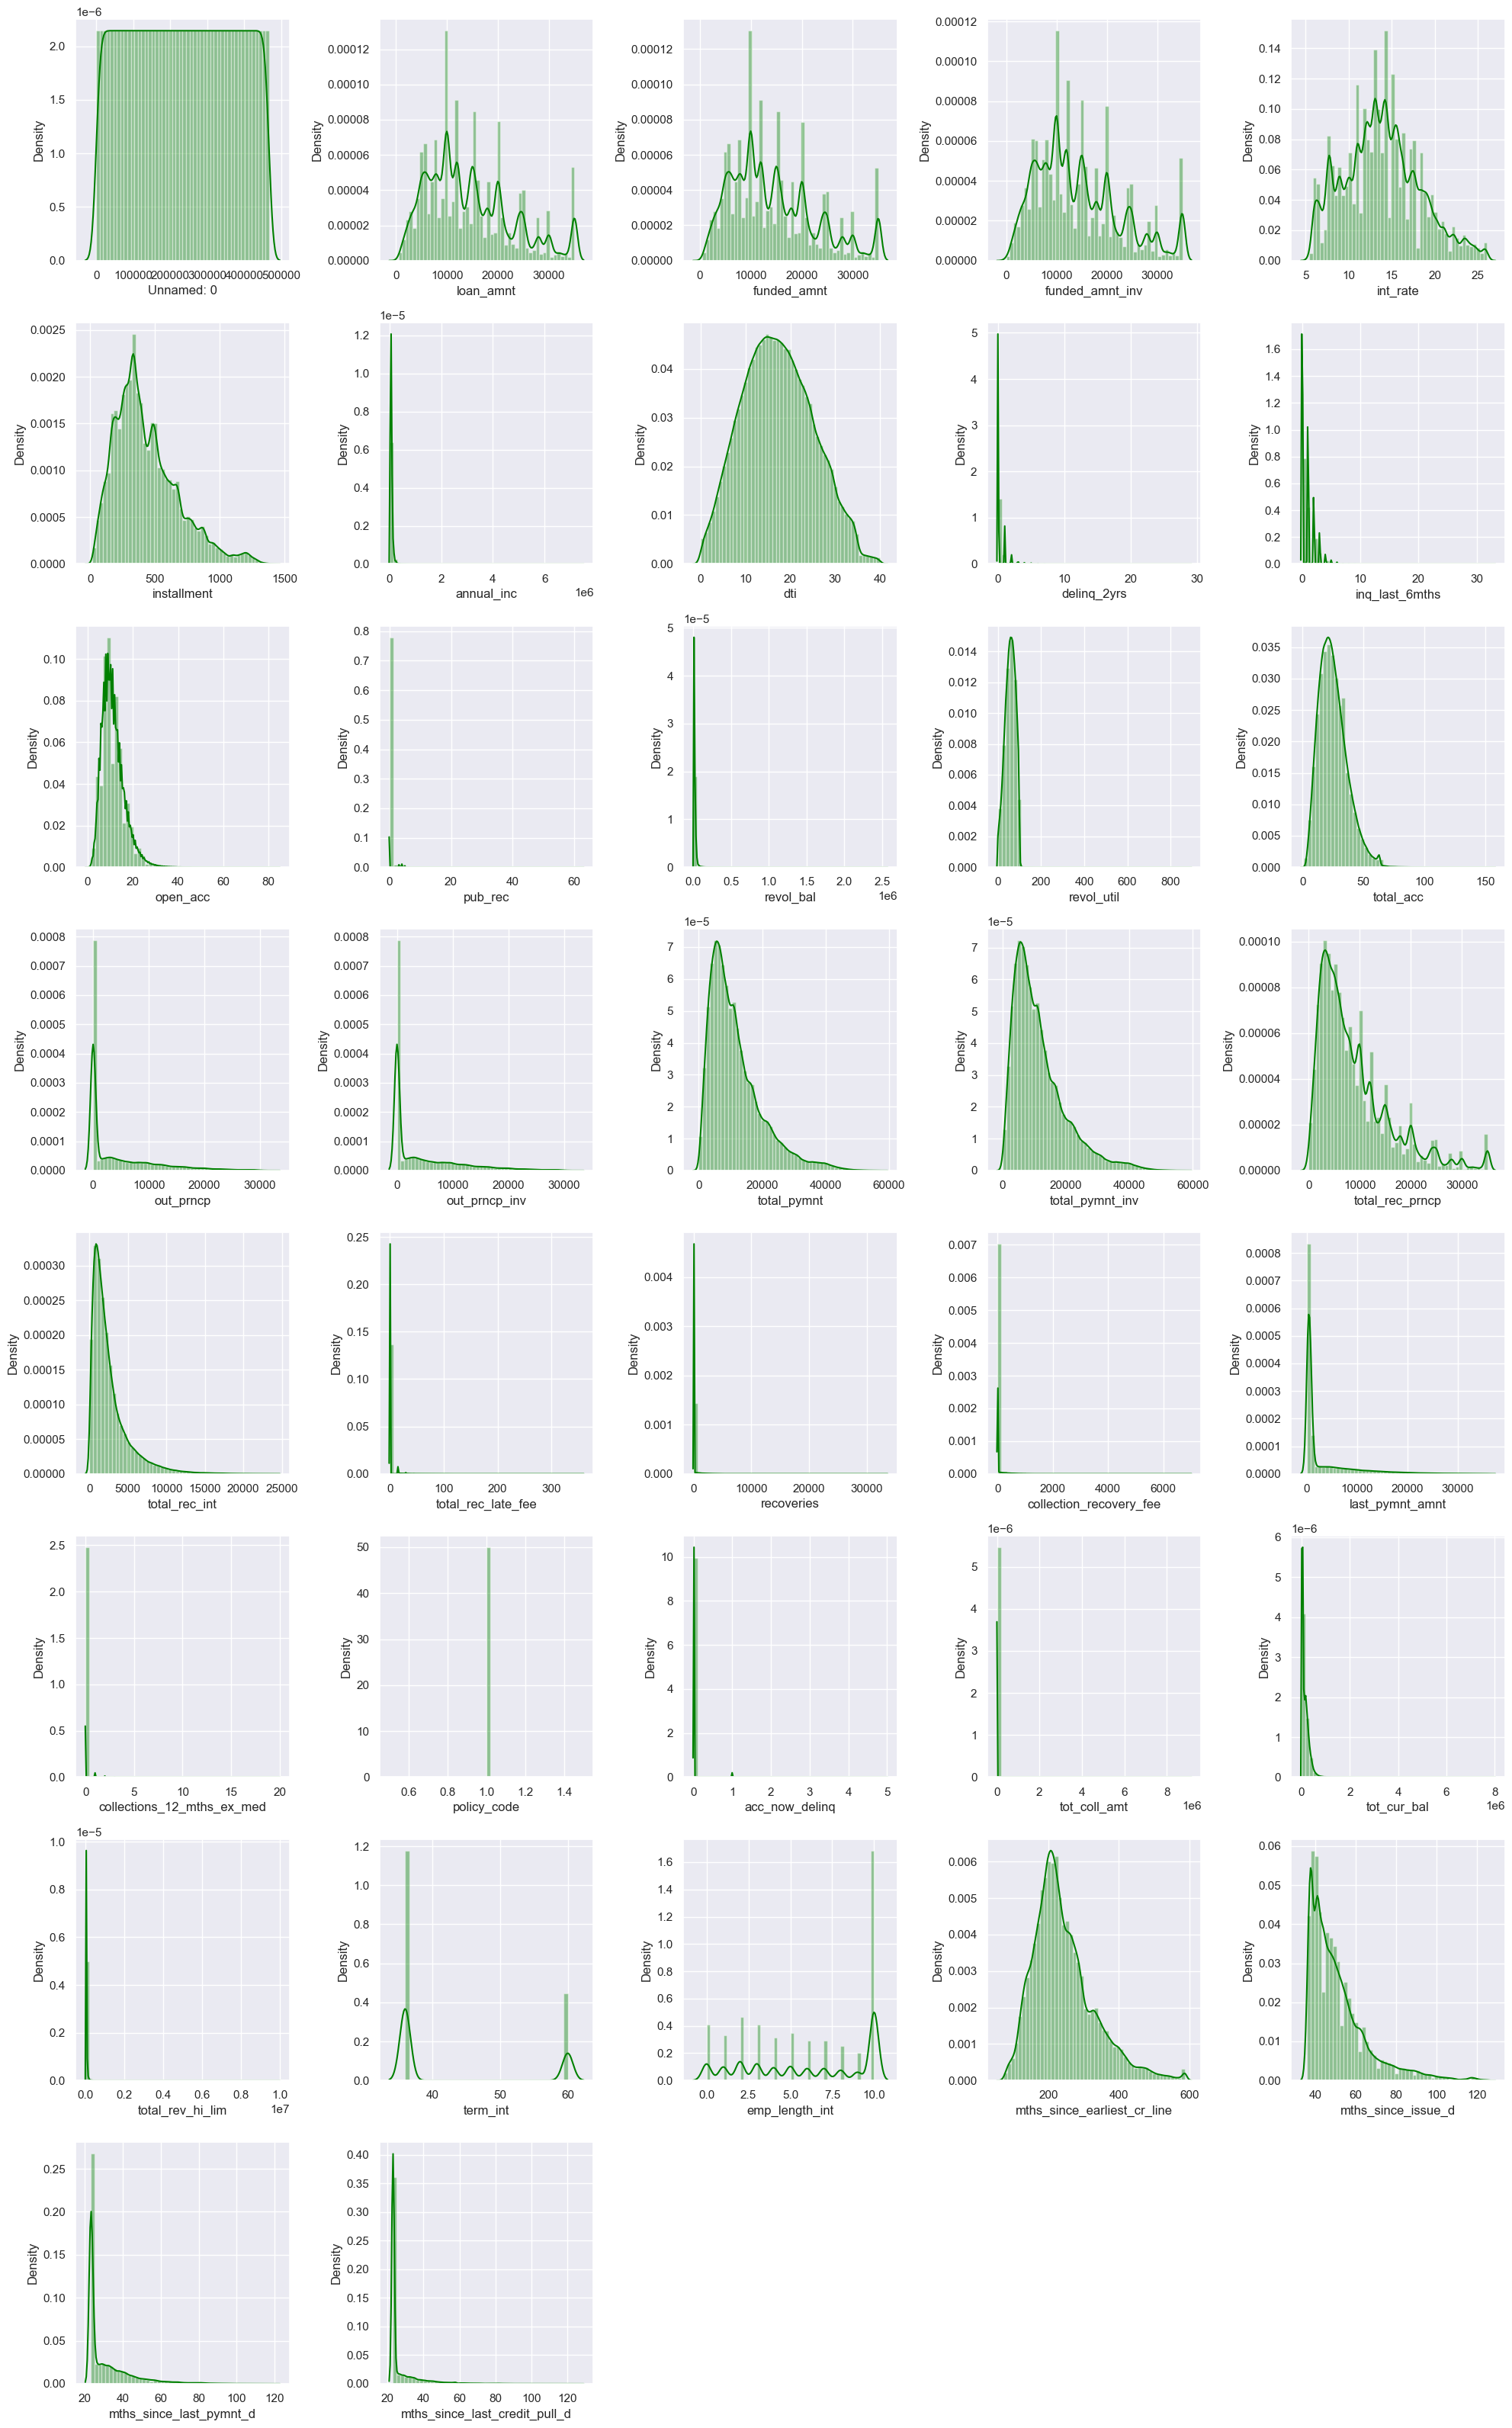

In [235]:
numeric_columns = df_eda.select_dtypes(include=['int64', 'float64']).columns

# Mentukan jumlah kolom dalam satu baris subplot
num_cols_subplot = 5

# Menghitung jumlah baris yang dibutuhkan
num_rows = (len(numeric_columns) + num_cols_subplot - 1) // num_cols_subplot

plt.figure(figsize=(20, 4 * num_rows))

for i, col in enumerate(numeric_columns):
    plt.subplot(num_rows, num_cols_subplot, i + 1)
    sns.distplot(df_eda[col], color='green')  # Plot distribusi
    plt.xlabel(col)  # Atur label untuk sumbu x

plt.tight_layout()  # Agar plot tidak saling tumpang tindih
plt.show()

## **Univariate Statistics**

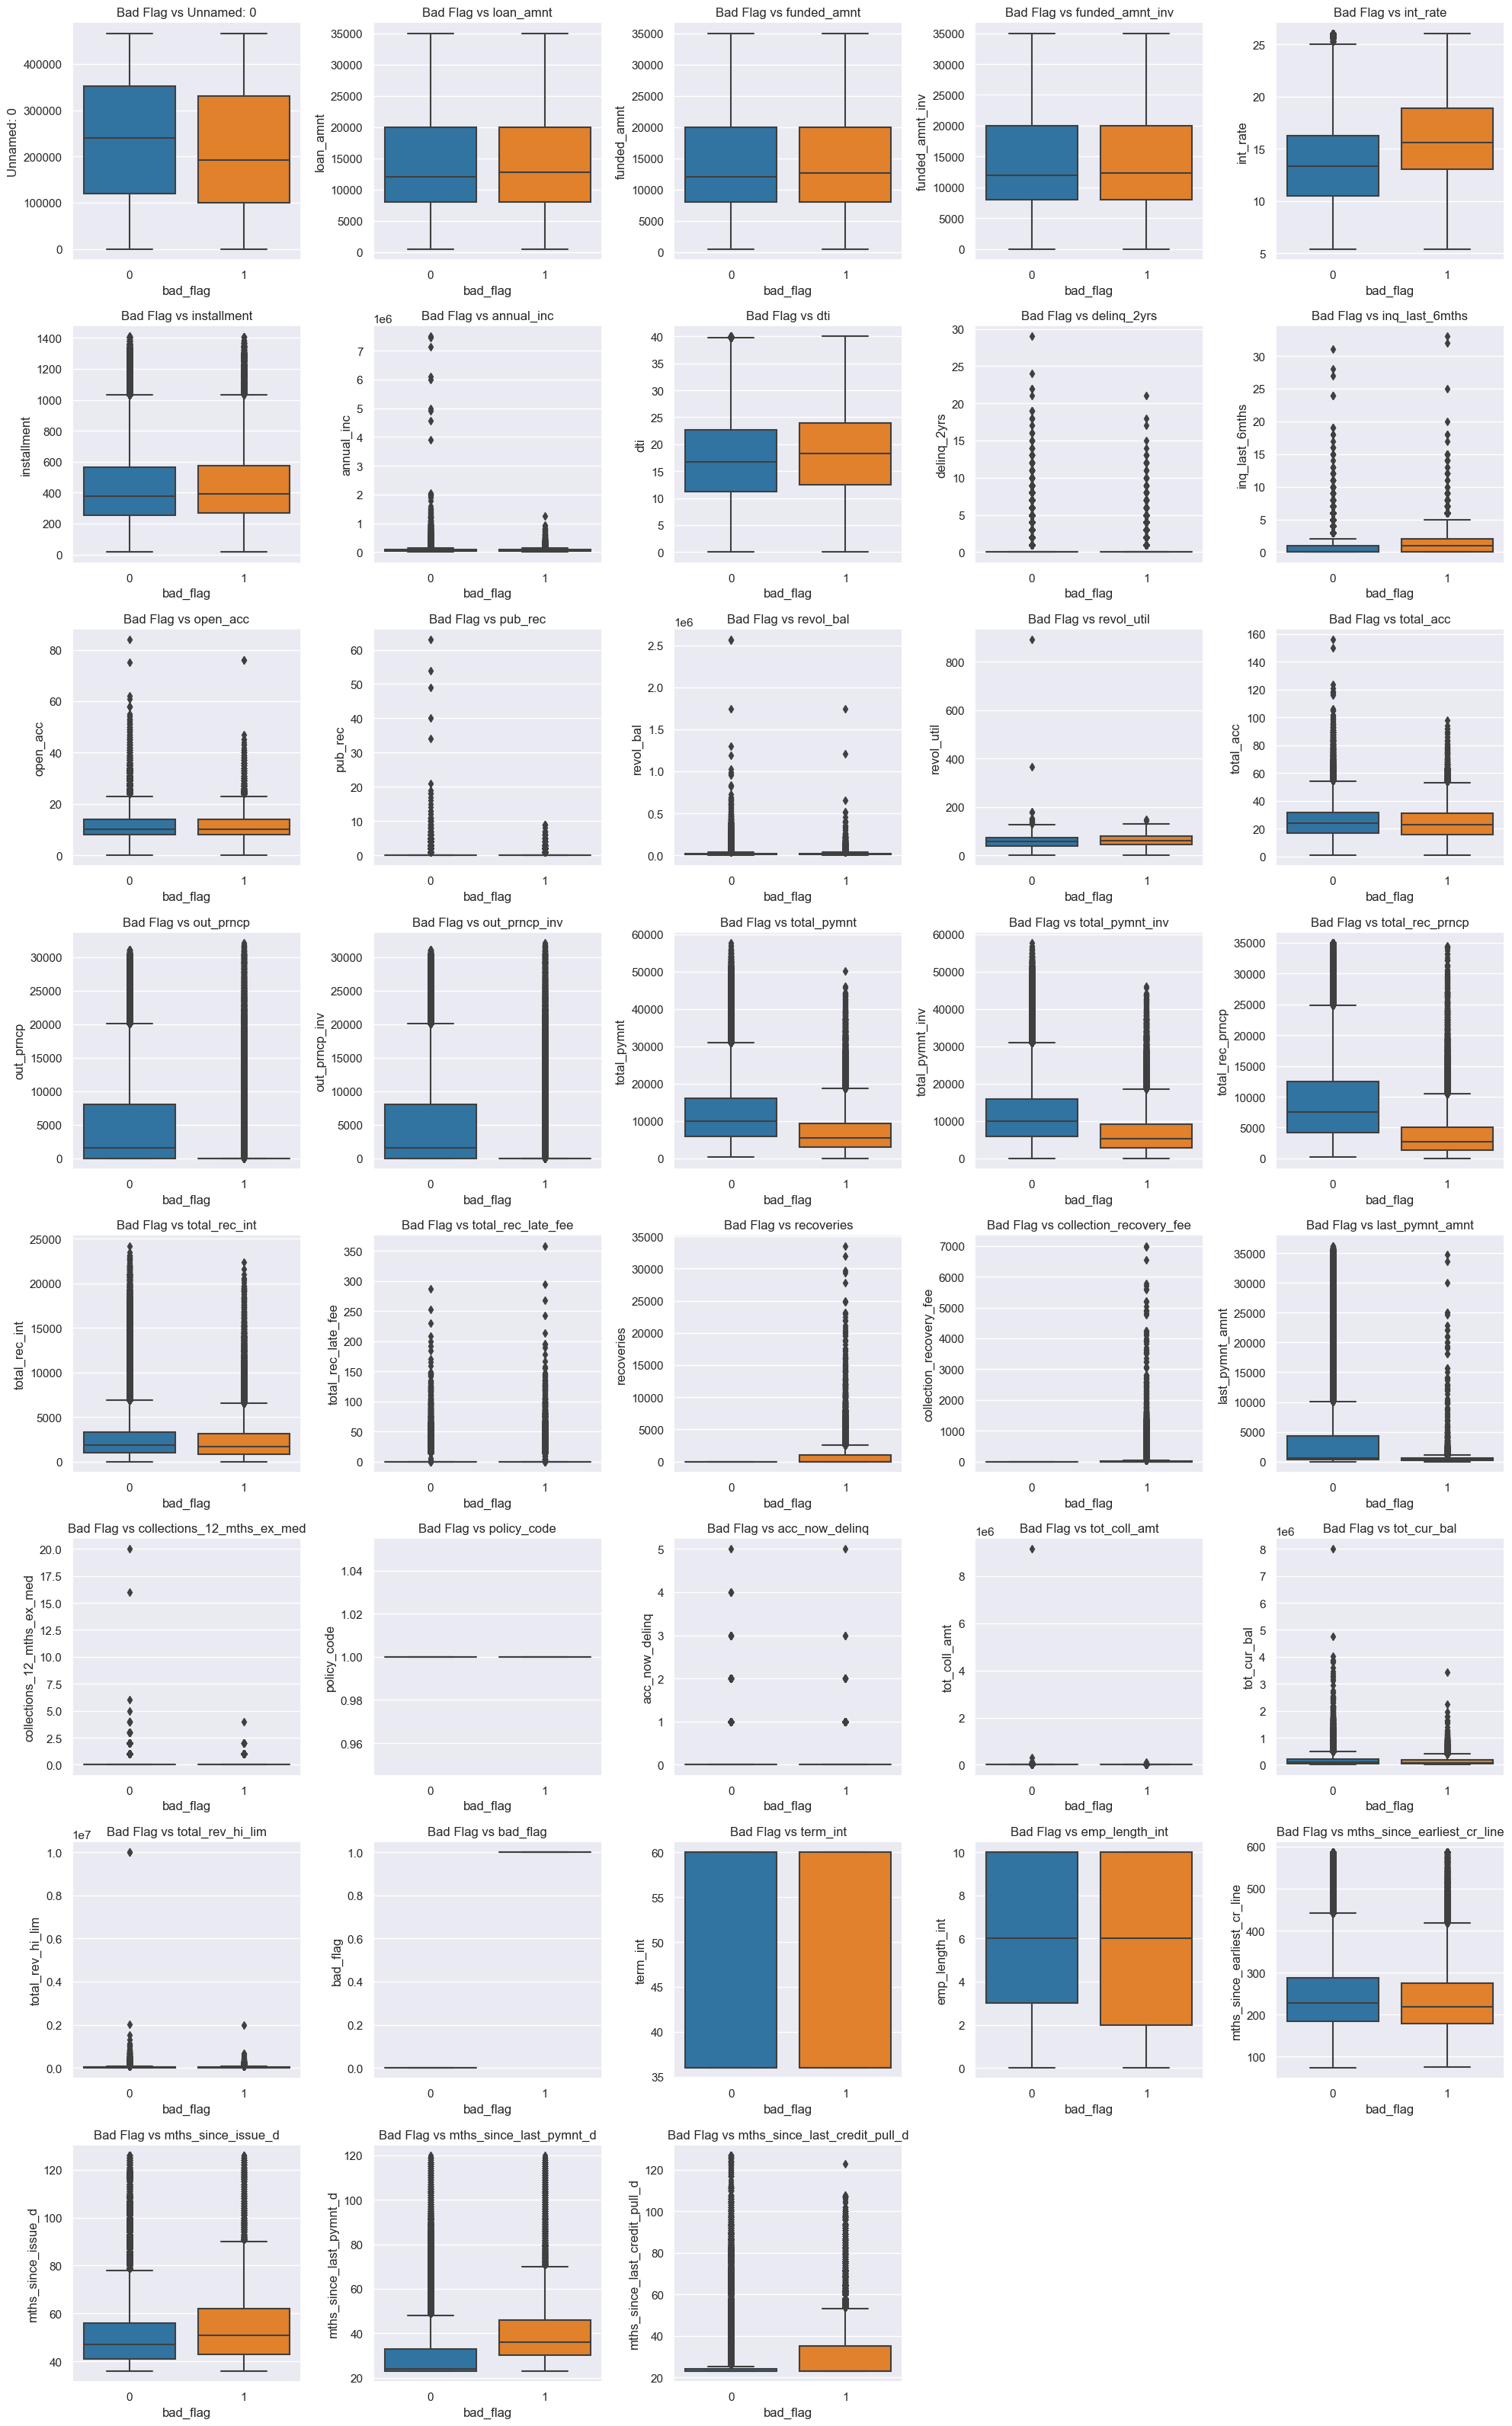

In [239]:
# Jumlah kolom dalam satu baris subplot
n_cols = 5

# Jumlah baris yang dibutuhkan
n_rows = (len(num_col_eda) + n_cols - 1) // n_cols

plt.figure(figsize=(20, 4 * n_rows))

# Loop melalui setiap fitur dan buat subplot
for i, feature in enumerate(num_col_eda, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df_eda, x='bad_flag', y=feature, palette='tab10')
    plt.title(f'Bad Flag vs {feature}')

plt.tight_layout()  # Agar plot tidak saling tumpang tindih
plt.show()

# **C. Data Preparation**

In [91]:
df = df_new1.copy()

## **Null Value**

In [92]:
null_value_new = df.isnull().sum() * 100 / df.shape[0]
null_value_new = null_value_new[null_value_new > 0]
null_value_new

emp_title                         5.916553
annual_inc                        0.000858
title                             0.004504
delinq_2yrs                       0.006219
inq_last_6mths                    0.006219
open_acc                          0.006219
pub_rec                           0.006219
revol_util                        0.072917
total_acc                         0.006219
collections_12_mths_ex_med        0.031097
acc_now_delinq                    0.006219
tot_coll_amt                     15.071469
tot_cur_bal                      15.071469
total_rev_hi_lim                 15.071469
emp_length_int                    4.505399
mths_since_earliest_cr_line       0.006219
mths_since_last_pymnt_d           0.080637
mths_since_last_credit_pull_d     0.009007
dtype: float64

In [93]:
df = df.drop(['emp_title', 'title', 'loan_status'], axis=1)

In [94]:
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].mean())
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(df['delinq_2yrs'].mean())
df['inq_last_6mths'] = df['inq_last_6mths'].fillna(df['inq_last_6mths'].mean())
df['open_acc'] = df['open_acc'].fillna(df['open_acc'].mean())
df['pub_rec'] = df['pub_rec'].fillna(df['pub_rec'].mean())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())
df['total_acc'] = df['total_acc'].fillna(df['total_acc'].mean())
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].fillna(df['collections_12_mths_ex_med'].mean())
df['acc_now_delinq'] = df['acc_now_delinq'].fillna(df['acc_now_delinq'].mean())
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(df['tot_coll_amt'].mean())
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(df['tot_cur_bal'].mean())
df['total_rev_hi_lim'] = df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].mean())
df['emp_length_int'] = df['emp_length_int'].fillna(df['emp_length_int'].mean())
df['mths_since_earliest_cr_line'] = df['mths_since_earliest_cr_line'].fillna(df['mths_since_earliest_cr_line'].mean())
df['mths_since_last_pymnt_d'] = df['mths_since_last_pymnt_d'].fillna(df['mths_since_last_pymnt_d'].mean())
df['mths_since_last_credit_pull_d'] = df['mths_since_last_credit_pull_d'].fillna(df['mths_since_last_credit_pull_d'].mean())

In [95]:
df.isnull().sum()

Unnamed: 0                       0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
home_ownership                   0
annual_inc                       0
verification_status              0
pymnt_plan                       0
url                              0
purpose                          0
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                       0
total_acc                        0
initial_list_status              0
out_prncp                        0
out_prncp_inv                    0
total_pymnt                      0
total_pymnt_inv     

## **Outlier**

Tidak dilakukan handing outlier akan model machine learning kuat terhadap berbagai nilai

## **Feature Encoding**

In [96]:
df.select_dtypes(include='object').nunique()

grade                       7
sub_grade                  35
home_ownership              6
verification_status         3
pymnt_plan                  2
url                    466285
purpose                    14
zip_code                  888
addr_state                 50
initial_list_status         2
application_type            1
dtype: int64

Nilai unik pada kolom sub_grade, url, zip_code, purpose, dan addr_state cukup bervariasi sehingga akan didrop. Selain itu, nilai unik pada application_type juga akan didrop karena hanya 1.

In [97]:
df = df.drop(['sub_grade', 'url', 'zip_code', 'addr_state', 'purpose', 'application_type'], axis=1)

In [99]:
cat1 = ['grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'initial_list_status']

# Doing one-hot encoding on categorical columns
for cat in cat1:
    if df[cat].dtype == 'object':
        nominal_encoded = pd.get_dummies(df[cat], prefix=cat, dtype=int)
        df = pd.concat([df, nominal_encoded], axis=1)

# Deleting the categorical columns that have been encoded
df.drop(columns=cat1, inplace=True)

In [103]:
df.select_dtypes(include='object').nunique()

Series([], dtype: float64)

## **Data Train, Data Validasi, dan Data Test Split**

In [101]:
from sklearn.model_selection import train_test_split

X = df.drop(['bad_flag'],axis=1,inplace=False)
y = df['bad_flag']

Xmodel, Xtest, ymodel, ytest = train_test_split(X, y, test_size=0.10, random_state=123, stratify = y)

In [102]:
Xmodel.head()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,pymnt_plan_y,initial_list_status_f,initial_list_status_w
210666,210666,10000,10000,10000.0,15.80,350.59,24000.0,28.10,0.0,1.0,...,0,0,1,0,0,1,1,0,1,0
384843,384843,20975,20975,20975.0,13.98,716.68,50000.0,16.39,0.0,0.0,...,0,0,1,0,0,1,1,0,1,0
366447,366447,14400,14400,14400.0,9.17,300.11,70000.0,25.90,0.0,2.0,...,0,0,0,1,0,0,1,0,0,1
403524,403524,15000,15000,15000.0,11.99,498.15,112000.0,12.08,1.0,0.0,...,0,0,0,1,0,0,1,0,0,1
83211,83211,20000,20000,19950.0,10.99,654.68,50000.0,15.05,0.0,0.0,...,0,0,1,0,1,0,1,0,1,0


In [104]:
ymodel.value_counts()

bad_flag
0    373785
1     45871
Name: count, dtype: int64

In [105]:
ytest.value_counts()

bad_flag
0    41532
1     5097
Name: count, dtype: int64

In [106]:
X1 = Xmodel
y1 = ymodel

Xtrain, Xeval, ytrain, yeval = train_test_split (X1, y1, test_size = 0.2, random_state=123, stratify = y1)

In [107]:
ytrain.value_counts()

bad_flag
0    299027
1     36697
Name: count, dtype: int64

In [108]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=1, random_state=123)
Xtrain_under, ytrain_under = undersample.fit_resample(Xtrain, ytrain)

print('Random Undersampling')
print(pd.Series(ytrain_under).value_counts())

Random Undersampling
bad_flag
0    36697
1    36697
Name: count, dtype: int64


## **Standardization**

In [113]:
numerical_cols = [col for col in Xtrain_under.columns.tolist() if col not in ['bad_flag']]

In [114]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(Xtrain_under[numerical_cols]), columns=numerical_cols)

## **Feature Selection**

In [115]:
Xtrain_under_fs = Xtrain_under.copy()
ytrain_under_fs = ytrain_under.copy()

In [116]:
Xtrain_under_fs = pd.DataFrame(np.maximum(0, Xtrain_under_fs))  # Convert Xtrain_under1 to a pandas DataFrame
ytrain_under_fs = pd.Series(ytrain_under_fs)  # Convert ytrain_under1 to a pandas Series

# Calculate the Pearson correlation coefficient between each feature and the target variable
correlation_matrix = Xtrain_under_fs.corrwith(ytrain_under_fs)

# Create a DataFrame to store the correlation coefficients
correlation_df = pd.DataFrame({'Feature': correlation_matrix.index, 'Correlation with Target': correlation_matrix.values})

# Print the correlation coefficients
print(correlation_df)

                                Feature  Correlation with Target
0                            Unnamed: 0                -0.082821
1                             loan_amnt                 0.018268
2                           funded_amnt                 0.017182
3                       funded_amnt_inv                 0.011608
4                              int_rate                 0.271264
5                           installment                 0.022978
6                            annual_inc                -0.095043
7                                   dti                 0.073081
8                           delinq_2yrs                -0.002952
9                        inq_last_6mths                 0.112690
10                             open_acc                -0.012105
11                              pub_rec                -0.012472
12                            revol_bal                -0.030916
13                           revol_util                 0.079305
14                       

In [117]:
sorted_df = correlation_df.sort_values('Correlation with Target', ascending=False)
top_36_features = sorted_df.head(36)
feature_names = top_36_features['Feature'].tolist()

print(feature_names)

['mths_since_last_pymnt_d', 'recoveries', 'int_rate', 'collection_recovery_fee', 'mths_since_last_credit_pull_d', 'total_rec_late_fee', 'mths_since_issue_d', 'grade_E', 'inq_last_6mths', 'term_int', 'grade_D', 'grade_F', 'initial_list_status_f', 'revol_util', 'dti', 'home_ownership_RENT', 'verification_status_Verified', 'grade_G', 'installment', 'grade_C', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'home_ownership_OTHER', 'pymnt_plan_y', 'home_ownership_NONE', 'home_ownership_OWN', 'acc_now_delinq', 'delinq_2yrs', 'pymnt_plan_n', 'tot_coll_amt', 'collections_12_mths_ex_med', 'open_acc', 'pub_rec', 'verification_status_Source Verified', 'emp_length_int']


# **D. Modelling**

In [118]:
Xtrain_under1 = Xtrain_under.copy()
Xeval1 = Xeval.copy()
ytrain_under1 = ytrain_under.copy()
yeval1 = yeval.copy()
Xtest1 = Xtest.copy()
ytest1 = ytest.copy()

In [119]:
Xtrain_under1 = Xtrain_under1[['mths_since_last_pymnt_d', 'recoveries', 'int_rate', 'collection_recovery_fee', 'mths_since_last_credit_pull_d', 'total_rec_late_fee', 'mths_since_issue_d', 'grade_E', 'inq_last_6mths', 'term_int', 'grade_D', 'grade_F', 'initial_list_status_f', 'revol_util', 'dti', 'home_ownership_RENT', 'verification_status_Verified', 'grade_G', 'installment', 'grade_C', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'home_ownership_OTHER', 'pymnt_plan_y', 'home_ownership_NONE', 'home_ownership_OWN', 'acc_now_delinq', 'delinq_2yrs', 'pymnt_plan_n', 'tot_coll_amt', 'collections_12_mths_ex_med', 'open_acc', 'pub_rec', 'verification_status_Source Verified', 'emp_length_int']]
Xeval1 = Xeval1[['mths_since_last_pymnt_d', 'recoveries', 'int_rate', 'collection_recovery_fee', 'mths_since_last_credit_pull_d', 'total_rec_late_fee', 'mths_since_issue_d', 'grade_E', 'inq_last_6mths', 'term_int', 'grade_D', 'grade_F', 'initial_list_status_f', 'revol_util', 'dti', 'home_ownership_RENT', 'verification_status_Verified', 'grade_G', 'installment', 'grade_C', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'home_ownership_OTHER', 'pymnt_plan_y', 'home_ownership_NONE', 'home_ownership_OWN', 'acc_now_delinq', 'delinq_2yrs', 'pymnt_plan_n', 'tot_coll_amt', 'collections_12_mths_ex_med', 'open_acc', 'pub_rec', 'verification_status_Source Verified', 'emp_length_int']]

## **Model Evaluation**

In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(Xeval1)
    y_pred_train = model.predict(Xtrain_under1)
    y_pred_proba = model.predict_proba(Xeval1)
    y_pred_proba_train = model.predict_proba(Xtrain_under1)

    print("Accuracy (Train Set): %.2f" % accuracy_score(ytrain_under1, y_pred_train))
    print("Accuracy (Eval Set): %.2f" % accuracy_score(yeval1, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(ytrain_under1, y_pred_train))
    print("Precision (Eval Set): %.2f" % precision_score(yeval1, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(ytrain_under1, y_pred_train))
    print("Recall (Eval Set): %.2f" % recall_score(yeval1, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(ytrain_under1, y_pred_train))
    print("F1-Score (Eval Set): %.2f" % f1_score(yeval1, y_pred))

    print("AUC (Train-proba): %.2f" % roc_auc_score(ytrain_under1, y_pred_proba_train[:, 1]))
    print("AUC (Eval-proba): %.2f" % roc_auc_score(yeval1, y_pred_proba[:, 1]))

    score = cross_validate(model, X=Xtrain_under1, y=ytrain_under1, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (Crossval  Train): '+ str(score['train_score'].mean()))
    print('roc_auc (Crossval  Eval): '+ str(score['test_score'].mean()))

## **Logistic Regression**

In [121]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(Xtrain_under1, ytrain_under1)

LogisticRegression()

In [122]:
eval_classification(logreg)

Accuracy (Train Set): 0.76
Accuracy (Eval Set): 0.87
Precision (Train Set): 0.86
Precision (Eval Set): 0.44
Recall (Train Set): 0.62
Recall (Eval Set): 0.62
F1-Score (Train Set): 0.72
F1-Score (Eval Set): 0.51
AUC (Train-proba): 0.86
AUC (Eval-proba): 0.85
roc_auc (Crossval  Train): 0.877059067121872
roc_auc (Crossval  Eval): 0.877335233247759


param value: 1e-06; train: 0.8213464500413405; test: 0.8170866122003326
param value: 0.0010213877551020407; train: 0.8421520178299327; test: 0.8332674117388864
param value: 0.0020417755102040817; train: 0.8538221042126295; test: 0.84783322917631
param value: 0.0030621632653061222; train: 0.8553207121018929; test: 0.8486070376763339
param value: 0.004082551020408163; train: 0.8588013024950796; test: 0.8521745753828996
param value: 0.005102938775510204; train: 0.8805421633982737; test: 0.8766957492135673
param value: 0.006123326530612244; train: 0.8586531600189754; test: 0.852635195434147
param value: 0.007143714285714285; train: 0.8589403959823978; test: 0.8531067657225998
param value: 0.008164102040816325; train: 0.8568768663915299; test: 0.8518574544721069
param value: 0.009184489795918366; train: 0.859138408886688; test: 0.8531803991418909
param value: 0.010204877551020407; train: 0.8597154575401935; test: 0.8536018068457127
param value: 0.011225265306122448; train: 0.859796339282155

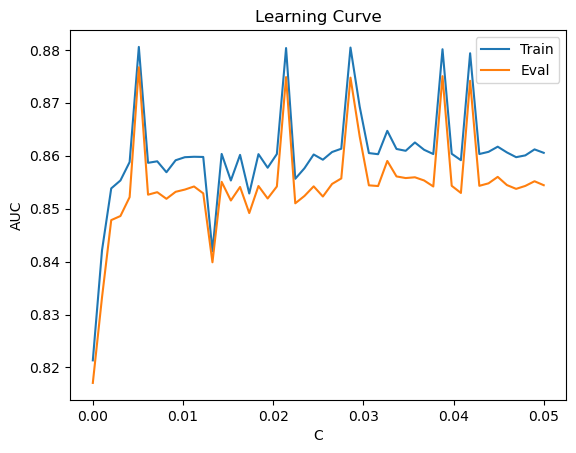

In [123]:
# Analyzing Learning Curve
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

param_values = [float(x) for x in np.linspace(0.000001, 0.05, 50)]
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(Xtrain_under1, ytrain_under1)

        # eval on train
        y_pred_train_proba = model.predict_proba(Xtrain_under1)
        train_auc = roc_auc_score(ytrain_under1, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(Xeval1)
        test_auc = roc_auc_score(yeval1, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Eval')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

draw_learning_curve(param_values)

In [124]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [0.006, 0.01, 0.02]
hyperparameters = dict(penalty=penalty, C=C)

lr = LogisticRegression()
lr_tuned = RandomizedSearchCV(lr, hyperparameters, scoring='roc_auc', cv=5)
lr_tuned.fit(Xtrain_under1, ytrain_under1)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': [0.006, 0.01, 0.02],
                                        'penalty': ['l1', 'l2']},
                   scoring='roc_auc')

In [125]:
eval_classification(lr_tuned)

Accuracy (Train Set): 0.76
Accuracy (Eval Set): 0.87
Precision (Train Set): 0.85
Precision (Eval Set): 0.42
Recall (Train Set): 0.63
Recall (Eval Set): 0.63
F1-Score (Train Set): 0.73
F1-Score (Eval Set): 0.50
AUC (Train-proba): 0.86
AUC (Eval-proba): 0.86
roc_auc (Crossval  Train): 0.872042179485562
roc_auc (Crossval  Eval): 0.8716699847851302


## **Random Forest**

In [130]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=123)
rf.fit(Xtrain_under1, ytrain_under1)

RandomForestClassifier(random_state=123)

In [131]:
eval_classification(rf)

Accuracy (Train Set): 1.00
Accuracy (Eval Set): 0.89
Precision (Train Set): 1.00
Precision (Eval Set): 0.49
Recall (Train Set): 1.00
Recall (Eval Set): 0.92
F1-Score (Train Set): 1.00
F1-Score (Eval Set): 0.64
AUC (Train-proba): 1.00
AUC (Eval-proba): 0.96
roc_auc (Crossval  Train): 1.0
roc_auc (Crossval  Eval): 0.9635447889693086


param value: 1; train: 0.8825043106762038; test: 0.8777388336698513
param value: 3; train: 0.94603816019759; test: 0.9418648873939721
param value: 6; train: 0.9590688254599463; test: 0.9554659240486998
param value: 9; train: 0.9657404801892309; test: 0.9592061467043784
param value: 12; train: 0.9756890005395524; test: 0.9618634426625429
param value: 15; train: 0.9866667464585597; test: 0.9635469242568389


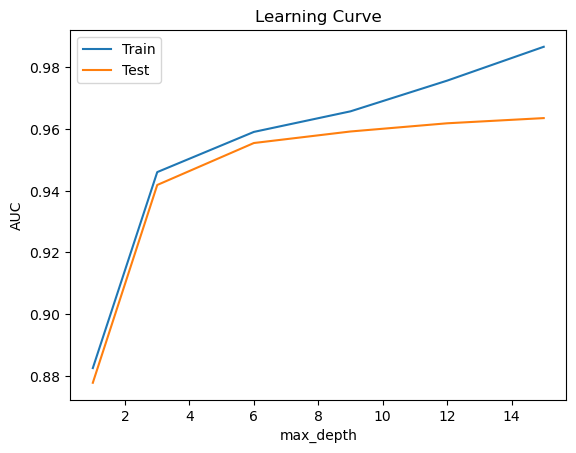

In [132]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = RandomForestClassifier(max_depth=i)
        model.fit(Xtrain_under1, ytrain_under1)

        # eval on train
        y_pred_train_proba = model.predict_proba(Xtrain_under1)
        train_auc = roc_auc_score(ytrain_under1, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(Xeval1)
        test_auc = roc_auc_score(yeval1, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

param_values = [int(x) for x in np.linspace(1, 15, 6)]
draw_learning_curve(param_values)

param value: 200; train: 0.9718495047957223; test: 0.9623670135975934
param value: 216; train: 0.9711223703538157; test: 0.9620549959930881
param value: 233; train: 0.9705625820560739; test: 0.9616025397738133
param value: 250; train: 0.9699701302206886; test: 0.9615681084953352
param value: 266; train: 0.9694612608635381; test: 0.9616670557718998
param value: 283; train: 0.9693589068944516; test: 0.9615920998672365
param value: 300; train: 0.9686051987521761; test: 0.9610980239980559
param value: 316; train: 0.9685909747754655; test: 0.9609504597096216
param value: 333; train: 0.9685031054260458; test: 0.9613575139999877
param value: 350; train: 0.968056383448632; test: 0.9611748637517831
param value: 366; train: 0.9676502623665784; test: 0.9609893556520573
param value: 383; train: 0.9676133579972461; test: 0.9609984628666491
param value: 400; train: 0.9671691912118897; test: 0.961005177359636
param value: 416; train: 0.9669544392377478; test: 0.9608634359436756
param value: 433; trai

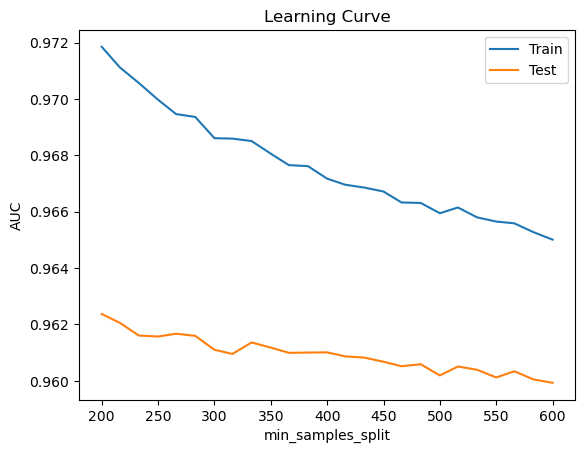

In [137]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = RandomForestClassifier(min_samples_split=i)
        model.fit(Xtrain_under1, ytrain_under1)

        # eval on train
        y_pred_train_proba = model.predict_proba(Xtrain_under1)
        train_auc = roc_auc_score(ytrain_under1, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(Xeval1)
        test_auc = roc_auc_score(yeval1, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('min_samples_split')
    plt.ylabel('AUC')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

param_values = [int(x) for x in np.linspace(200, 600, 25)]
draw_learning_curve(param_values)

param value: 1; train: 0.9999999996287137; test: 0.9626138459418448
param value: 5; train: 0.9917209260016908; test: 0.9629778815473384
param value: 9; train: 0.9857559352175244; test: 0.9629847236229825
param value: 13; train: 0.9814320839207289; test: 0.9627635448703948
param value: 17; train: 0.9784523171113878; test: 0.9622638626547355
param value: 21; train: 0.976246893792211; test: 0.9621042399825874
param value: 25; train: 0.9750740145983328; test: 0.9620539272149427
param value: 29; train: 0.9736691713417628; test: 0.9618595889372522
param value: 34; train: 0.9718956631038573; test: 0.961312123735779
param value: 38; train: 0.9716733732760173; test: 0.9619347256447669
param value: 42; train: 0.9709276604121151; test: 0.9615059604313658
param value: 46; train: 0.97007804160255; test: 0.9610921508215627
param value: 50; train: 0.9694231594672962; test: 0.9611916375905062
param value: 54; train: 0.968978738722136; test: 0.9608540859575131
param value: 58; train: 0.9684596107255568

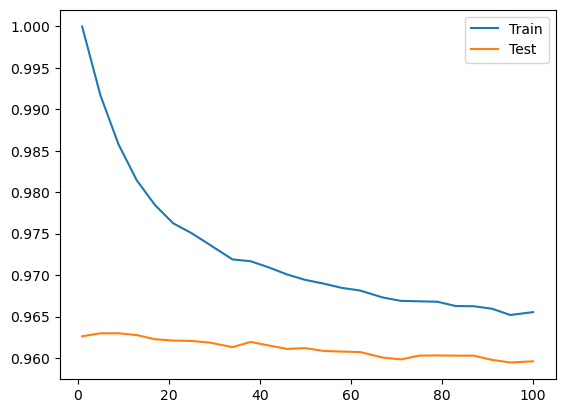

In [138]:
param_values = [int(x) for x in np.linspace(1, 100, 25)] # min_samples_leaf

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(n_estimators=75, min_samples_leaf=c)
    model.fit(Xtrain_under1, ytrain_under1)

    # eval on train
    y_pred_train_proba = model.predict_proba(Xtrain_under1)
    train_auc = roc_auc_score(ytrain_under1, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # eval on test
    y_pred_proba = model.predict_proba(Xeval1)
    test_auc = roc_auc_score(yeval1, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()
plt.show()

In [141]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(100, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(1, 2)]
min_samples_split = [int(x) for x in np.linspace(250, 260, 5)]
min_samples_leaf = [int(x) for x in np.linspace(80, 100, 10)]
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf = RandomForestClassifier(random_state=123)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, scoring='roc_auc', random_state=123, cv=5)
rf_tuned.fit(Xtrain_under1, ytrain_under1)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 1, 1, 1, 1, 1, 1, 1, 1,
                                                      1, 1, 1, 1, 1, 1, 1, 1, 1,
                                                      1, 1, 1, 1, 1, 1, 1, 1, 1,
                                                      1, 1, 1, ...],
                                        'min_samples_leaf': [80, 82, 84, 86, 88,
                                                             91, 93, 95, 97,
                                                             100],
                                        'min_samples_split': [250, 252, 255,
                                                              257, 260],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 151, 153, 155,
                                                         157, 159, ...]},
                   random_state=123, scoring='roc_auc')

In [142]:
eval_classification(rf_tuned)

Accuracy (Train Set): 0.80
Accuracy (Eval Set): 0.92
Precision (Train Set): 0.93
Precision (Eval Set): 0.61
Recall (Train Set): 0.65
Recall (Eval Set): 0.64
F1-Score (Train Set): 0.77
F1-Score (Eval Set): 0.62
AUC (Train-proba): 0.92
AUC (Eval-proba): 0.92
roc_auc (Crossval  Train): 0.9250764279553894
roc_auc (Crossval  Eval): 0.924731957863566


## **XGBoost**

In [126]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(Xtrain_under1, ytrain_under1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [127]:
eval_classification(xg)

Accuracy (Train Set): 0.93
Accuracy (Eval Set): 0.89
Precision (Train Set): 0.92
Precision (Eval Set): 0.51
Recall (Train Set): 0.95
Recall (Eval Set): 0.92
F1-Score (Train Set): 0.93
F1-Score (Eval Set): 0.65
AUC (Train-proba): 0.98
AUC (Eval-proba): 0.97
roc_auc (Crossval  Train): 0.9844773150946244
roc_auc (Crossval  Eval): 0.9678006718967783


In [128]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Define the hyperparameters dictionary
hyperparameters = {
    'max_depth': [1],  # Narrowing down the range
    'min_child_weight': [1],  # Narrowing down the range
    'gamma': [0, 0.01, 0.02, 0.05],  # Narrowing down the range
    'tree_method': ['auto'],  # Limiting the options
    'colsample_bytree': [0, 0.01, 0.02, 0.05],  # Narrowing down the range
    'eta': [0, 0.01, 0.02, 0.05],  # Narrowing down the range
    'lambda': [0, 0.01, 0.02, 0.05],  # Narrowing down the range
    'alpha': [0, 0.01, 0.02, 0.05]  # Narrowing down the range
}

# Initialize the XGBoost classifier
xg = XGBClassifier(random_state=123)

# Perform RandomizedSearchCV with more conservative hyperparameters
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=123, scoring='recall', n_iter=20)
xg_tuned.fit(Xtrain_under1, ytrain_under1)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=123, ...),
                   n_iter=20,
                   param_distributions={'alpha': [0, 0.01, 0.02, 0.05],
                                        'colsample_bytree': [0, 0.01, 0.02,
                                                             0.05],
                                        'eta': [0, 0.01, 0.02, 0.05],
                                        'gamma': [0, 0.01, 0.02, 0.05],
                                        'lambda': [0, 0.01, 0.02, 0.05],
                                        'max_depth': [1],
                                        'min_child_weight': [1],
                                        'tree_method': ['auto']},
                   random_state=123, scoring='recall')

In [129]:
eval_classification(xg_tuned)

Accuracy (Train Set): 0.74
Accuracy (Eval Set): 0.87
Precision (Train Set): 0.87
Precision (Eval Set): 0.44
Recall (Train Set): 0.56
Recall (Eval Set): 0.55
F1-Score (Train Set): 0.68
F1-Score (Eval Set): 0.49
AUC (Train-proba): 0.88
AUC (Eval-proba): 0.87
roc_auc (Crossval  Train): 0.8755180885657989
roc_auc (Crossval  Eval): 0.874819001109896


# **E. Evaluation**

In [143]:
Xtest1 = Xtest1[['mths_since_last_pymnt_d', 'recoveries', 'int_rate', 'collection_recovery_fee', 'mths_since_last_credit_pull_d', 'total_rec_late_fee', 'mths_since_issue_d', 'grade_E', 'inq_last_6mths', 'term_int', 'grade_D', 'grade_F', 'initial_list_status_f', 'revol_util', 'dti', 'home_ownership_RENT', 'verification_status_Verified', 'grade_G', 'installment', 'grade_C', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'home_ownership_OTHER', 'pymnt_plan_y', 'home_ownership_NONE', 'home_ownership_OWN', 'acc_now_delinq', 'delinq_2yrs', 'pymnt_plan_n', 'tot_coll_amt', 'collections_12_mths_ex_med', 'open_acc', 'pub_rec', 'verification_status_Source Verified', 'emp_length_int']]

In [152]:
from sklearn.metrics import confusion_matrix


def confusion(model):
    y_pred_proba = model.predict_proba(Xtest1)
    y_predict = model.predict(Xtest1)
    print('Accuracy: %.2f%%' % (accuracy_score(ytest1, y_predict) * 100))
    print('Precision: %.2f%%' % (precision_score(ytest1, y_predict) * 100))
    print('Recall: %.2f%%' % (recall_score(ytest1, y_predict) * 100))
    print('F1_Score: %.2f%%' % (f1_score(ytest1, y_predict) * 100))
    print('ROC_AUC: %.2f%%' % (roc_auc_score(ytest1, y_pred_proba[:,1]) * 100))
    confusion_matrix_model = confusion_matrix(ytest1, y_predict)

    plt.figure(figsize=(4,3))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix - {model.__class__.__name__}')
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show()

Accuracy: 86.27%
Precision: 41.39%
Recall: 61.66%
F1_Score: 49.54%
ROC_AUC: 85.23%


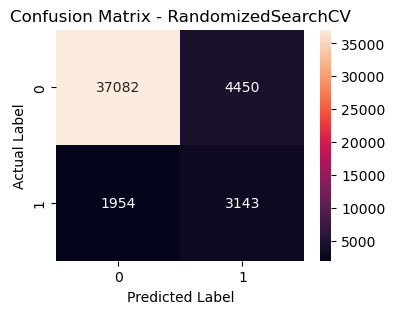

In [153]:
confusion(lr_tuned)

Accuracy: 92.34%
Precision: 65.20%
Recall: 64.14%
F1_Score: 64.66%
ROC_AUC: 92.76%


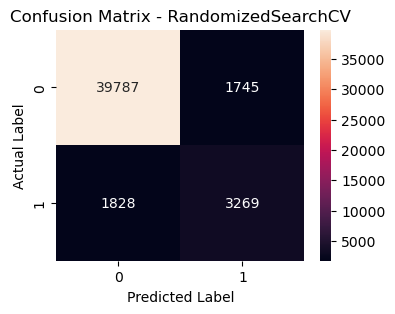

In [154]:
confusion(rf_tuned)

Accuracy: 87.44%
Precision: 44.11%
Recall: 55.82%
F1_Score: 49.28%
ROC_AUC: 87.24%


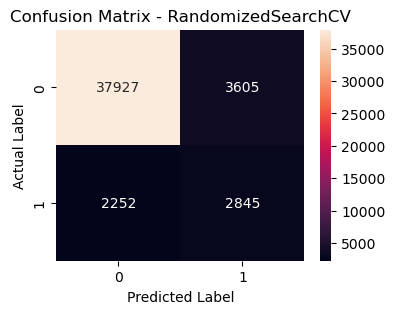

In [155]:
confusion(xg_tuned)

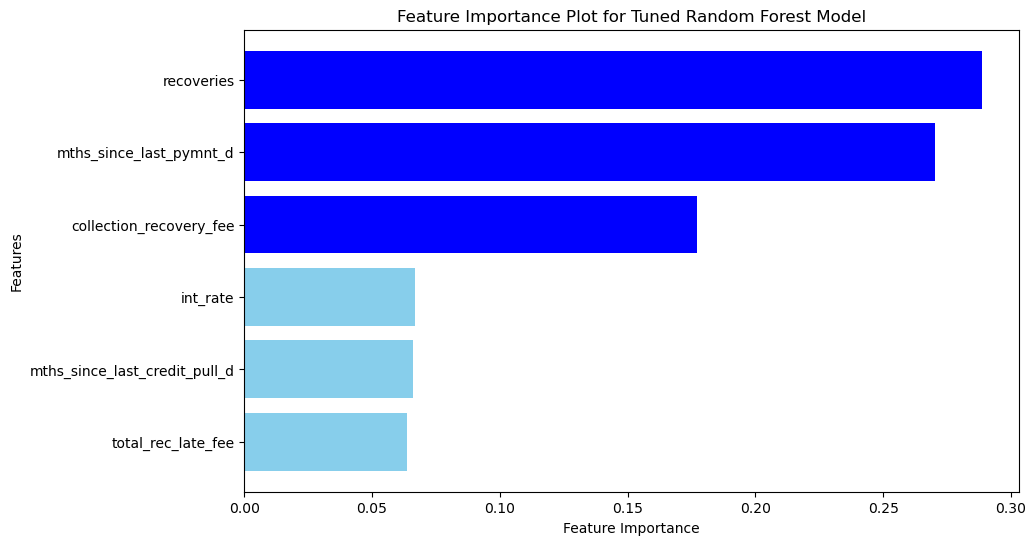

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameter tuning untuk Random Forest
n_estimators = [int(x) for x in np.linspace(100, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(1, 2, 2)]
min_samples_split = [int(x) for x in np.linspace(250, 260, 5)]
min_samples_leaf = [int(x) for x in np.linspace(80, 100, 10)]
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

# Membuat model Random Forest
rf = RandomForestClassifier(random_state=123)

# Randomized Search CV untuk mencari hyperparameter terbaik
rf_tuned = RandomizedSearchCV(rf, hyperparameters, scoring='roc_auc', random_state=123, cv=5)
rf_tuned.fit(Xtrain_under1, ytrain_under1)

# Extract feature importances from the best estimator
best_rf = rf_tuned.best_estimator_
feature_importance_tuned = best_rf.feature_importances_

# Sort the indices of feature importances
sorted_idx_tuned = np.argsort(feature_importance_tuned)

# Get the sorted features and their importances
sorted_features_tuned = Xtrain_under1.columns[sorted_idx_tuned]
sorted_importance_tuned = feature_importance_tuned[sorted_idx_tuned]

# Select the top features and their importances
top_n = 6  # number of top features to select
top_features_tuned = sorted_features_tuned[-top_n:]
top_importance_tuned = sorted_importance_tuned[-top_n:]

# Set colors for top 3 features
colors = ['blue' if feature in top_features_tuned[-3:] else 'skyblue' for feature in top_features_tuned]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features_tuned, top_importance_tuned, color=colors)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot for Tuned Random Forest Model')
plt.show()